In [1]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn

%matplotlib inline

import pandas
import pickle
import pydot

Using TensorFlow backend.
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framewo

In [4]:
# import the data, Butte
dataButte = np.load('Butte/data_nadj4_stdTrue.npy')
dataLabelsButte = np.load('Butte/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsButte),1))
temp[:,0] = dataLabelsButte
dataLabelsButte = temp

# Kaweah
dataKaweah = np.load('Kaweah/data_nadj4_stdTrue.npy')
dataLabelsKaweah = np.load('Kaweah/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsKaweah),1))
temp[:,0] = dataLabelsKaweah
dataLabelsKaweah = temp

#data.closest_pos.hist()

In [5]:
print(np.shape(dataKaweah),np.shape(dataButte))

(24523, 4, 9, 37) (23411, 4, 9, 37)


In [6]:
# do the do for Butte
# reshuffle the vectors
data_preped=np.transpose(dataButte, (0, 2, 3, 1))

# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Butte=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Butte)[-1]):
    for j in range(np.shape(X_Butte)[1]):
        
        # do it for all examples, for this moment
        X_Butte[:,j,:,i] = min_max_scaler.fit_transform(X_Butte[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Butte)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Butte[:,j,k,i]=X_Butte[:,j,k,i]-X_Butte[:,j,k,i]

# reshuffle the vectors for Kaweah
data_preped=np.transpose(dataKaweah, (0, 2, 3, 1))

# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Kaweah=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Kaweah)[-1]):
    for j in range(np.shape(X_Kaweah)[1]):
        
        # do it for all examples, for this moment
        X_Kaweah[:,j,:,i] = min_max_scaler.fit_transform(X_Kaweah[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Kaweah)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Kaweah[:,j,k,i]=X_Kaweah[:,j,k,i]-X_Kaweah[:,j,k,i]

                    
# combine them
X_both=np.concatenate((X_Butte,X_Kaweah),axis=0)
dataLabelsBoth=np.concatenate((dataLabelsButte,dataLabelsKaweah),axis=0)


D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


In [7]:
print(np.shape(X_Butte),np.shape(X_Kaweah),np.shape(X_both))

(23411, 9, 37, 4) (24523, 9, 37, 4) (47934, 9, 37, 4)


In [25]:
# make some random indices, then take 20000 examples for training and the rest for test, results in about 85/15 split
# first is butte on butte
indices=np.random.permutation(X_Butte.shape[0])
X_train1=X_Butte[indices[:20000],:,:,:]
X_test1=X_Butte[indices[20000:],:,:,:]
Y_train1=dataLabelsButte[indices[:20000],:]
Y_test1=dataLabelsButte[indices[20000:],:]

# 2nd is Kaweah on Kaweah
indices=np.random.permutation(X_Kaweah.shape[0])
X_train2=X_Kaweah[indices[:20000],:,:,:]
X_test2=X_Kaweah[indices[20000:],:,:,:]
Y_train2=dataLabelsKaweah[indices[:20000],:]
Y_test2=dataLabelsKaweah[indices[20000:],:]

# 3rd is both on both
indices=np.random.permutation(X_both.shape[0])
X_train3=X_both[indices[:41000],:,:,:]
X_test3=X_both[indices[41000:],:,:,:]
Y_train3=dataLabelsBoth[indices[:41000],:]
Y_test3=dataLabelsBoth[indices[41000:],:]

# 4th is butte on Kaweah
X_train4=X_Butte
X_test4=X_Kaweah
Y_train4=dataLabelsButte
Y_test4=dataLabelsKaweah

# 5th is Kaweah on Butte
X_train5=X_Kaweah
X_test5=X_Butte
Y_train5=dataLabelsKaweah
Y_test5=dataLabelsButte

# 6th is butte with 0.5% of Kaweah
percentToUse=0.5
indices=np.random.permutation(X_Kaweah.shape[0])
X_train6=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test6=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train6=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test6=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 7th is butte with 1% of Kaweah
percentToUse=1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train7=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test7=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train7=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test7=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 8th is butte with 0.1% of Kaweah
percentToUse=0.1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train8=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test8=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train8=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test8=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]


# print out some shit
print ("number of training examples = " + str(X_train1.shape[0]))
print ("number of test examples = " + str(X_test1.shape[0]))
print ("X_train1 shape: " + str(X_train1.shape))
print ("Y_train1 shape: " + str(Y_train1.shape))
print ("X_test1 shape: " + str(X_test1.shape))
print ("Y_test1 shape: " + str(Y_test1.shape))

print ("number of training examples = " + str(X_train2.shape[0]))
print ("number of test examples = " + str(X_test2.shape[0]))
print ("X_train2 shape: " + str(X_train2.shape))
print ("Y_train2 shape: " + str(Y_train2.shape))
print ("X_test2 shape: " + str(X_test2.shape))
print ("Y_test2 shape: " + str(Y_test2.shape))

print ("number of training examples = " + str(X_train3.shape[0]))
print ("number of test examples = " + str(X_test3.shape[0]))
print ("X_train3 shape: " + str(X_train3.shape))
print ("Y_train3 shape: " + str(Y_train3.shape))
print ("X_test3 shape: " + str(X_test3.shape))
print ("Y_test3 shape: " + str(Y_test3.shape))

print ("number of training examples = " + str(X_train4.shape[0]))
print ("number of test examples = " + str(X_test4.shape[0]))
print ("X_train4 shape: " + str(X_train4.shape))
print ("Y_train4 shape: " + str(Y_train4.shape))
print ("X_test4 shape: " + str(X_test4.shape))
print ("Y_test4 shape: " + str(Y_test4.shape))

print ("number of training examples = " + str(X_train6.shape[0]))
print ("number of test examples = " + str(X_test6.shape[0]))
print ("X_train6 shape: " + str(X_train6.shape))
print ("Y_train6 shape: " + str(Y_train6.shape))
print ("X_test6 shape: " + str(X_test6.shape))
print ("Y_test6 shape: " + str(Y_test6.shape))

# look at a timegate to check the scaling
#plt.hist(X[:,1,3,0].flatten())

number of training examples = 20000
number of test examples = 3411
X_train1 shape: (20000, 9, 37, 4)
Y_train1 shape: (20000, 1)
X_test1 shape: (3411, 9, 37, 4)
Y_test1 shape: (3411, 1)
number of training examples = 20000
number of test examples = 4523
X_train2 shape: (20000, 9, 37, 4)
Y_train2 shape: (20000, 1)
X_test2 shape: (4523, 9, 37, 4)
Y_test2 shape: (4523, 1)
number of training examples = 41000
number of test examples = 6934
X_train3 shape: (41000, 9, 37, 4)
Y_train3 shape: (41000, 1)
X_test3 shape: (6934, 9, 37, 4)
Y_test3 shape: (6934, 1)
number of training examples = 23411
number of test examples = 24523
X_train4 shape: (23411, 9, 37, 4)
Y_train4 shape: (23411, 1)
X_test4 shape: (24523, 9, 37, 4)
Y_test4 shape: (24523, 1)
number of training examples = 25836
number of test examples = 22098
X_train6 shape: (25836, 9, 37, 4)
Y_train6 shape: (25836, 1)
X_test6 shape: (22098, 9, 37, 4)
Y_test6 shape: (22098, 1)


In [26]:
def model(input_shape):

    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)
    
    # initializer to use
    initToUse=keras.initializers.glorot_normal(seed=0)
    #initToUse=keras.initializers.he_normal(seed=0)
    
    # for the leakly relu
    alphaParam=0.3

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 3), strides = (1, 1), kernel_initializer=initToUse, name = 'conv0', padding='same')(X_input)
    X = MaxPooling2D((1, 2), name='max_pool0')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(32, (2, 5), strides = (1, 1), kernel_initializer=initToUse, name = 'conv1', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool1')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(64, (2, 7), strides = (1, 1), kernel_initializer=initToUse, name = 'conv2', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool2')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 9), strides = (1, 1), kernel_initializer=initToUse, name = 'conv3', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 11), strides = (1, 1), kernel_initializer=initToUse, name = 'conv4', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_final')(X)
    
    # make another initializer
    initToUse2=keras.initializers.he_normal(seed=0)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(200, activation='relu', kernel_initializer=initToUse2,name='fc0')(X)
    X = Dense(100, activation='relu', kernel_initializer=initToUse2,name='fc1')(X)
    X = Dense(50, activation='relu', kernel_initializer=initToUse2,name='fc2')(X)
    X = Dense(1, activation='sigmoid', kernel_initializer=initToUse,name='fc3')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    
    return model


def modelv2(inputShape,L2param,alpha):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=1)
    initToUse2=keras.initializers.he_normal(seed=1)

    # for the leakly relu
    alphaParam=alpha
    
    # short dim
    shortDim=3
    
    # add some regularization to the dense layers
    denseReg=keras.regularizers.l2(L2param)
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(160, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(96, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(32, activation='relu', kernel_regularizer=denseReg))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

def modelv3(inputShape,L2,alpha):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=1)
    initToUse2=keras.initializers.he_normal(seed=1)
    
    # short dim
    shortDim=3
    
    # add some regularization to the dense layers
    denseReg=keras.regularizers.l2(L2)
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    #model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(256, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(160, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(96, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(32, activation='relu', kernel_regularizer=denseReg))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

def trainEnsemble(modelType,ensembleSize,currTrainX,currTrainY,currTestX,currTestY,currLearingRate,currEpochNum,currL2param,currBatchSize,trialEpochNum,currAlphaParam,verbFlag):
    
    # make a list of models and other lists and arrays we need
    test_acc=np.zeros((ensembleSize,1))
    Models=[]
    adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=currLearingRate)
    
    # train the ensemble of models
    for i in range(ensembleSize):
        
        # make the flag for checking if the training got stuck
        whileFlag=1
        while whileFlag==1:

            # make the model based on the model type
            if modelType==1:
                tempModel = modelv2(currTrainX.shape[1:],currL2param,currAlphaParam)
            elif modelType==2:
                tempModel = modelv3(currTrainX.shape[1:],currL2param,currAlphaParam)
                

            # compile the model
            tempModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

            # fit the model
            tempModel.fit(x = currTrainX, y = currTrainY, epochs = trialEpochNum, batch_size = currBatchSize,  verbose=verbFlag)

            # test to see if it was stuck
            temp=tempModel.evaluate(x = currTrainX, y = currTrainY)

            if (temp[1]*100)>73:

                # train for all the epochs
                tempModel.fit(x = currTrainX, y = currTrainY, epochs = currEpochNum, batch_size = currBatchSize,  verbose=verbFlag)

                # predict and store the results
                temp=tempModel.evaluate(x = currTestX, y = currTestY)
                test_acc[i]=temp[1]

                # append the model and end the while loop
                Models.append(tempModel)
                whileFlag=0

    test_acc_var=np.var(100*test_acc)

    # get the mean label, round it and find the emsemble test acc
    meanLabels=(Models[0].predict(currTestX)+Models[1].predict(currTestX)+Models[2].predict(currTestX)+Models[3].predict(currTestX)+Models[4].predict(currTestX))/5
    meanLabels=np.round(meanLabels)
    wrongLabels=currTestY-meanLabels
    test_acc_mean=1-np.sum(np.abs(wrongLabels))/len(currTestY)

    print("\n Final ensemble test accuracy of: ",str(np.round(test_acc_mean*100,2)),", mean test accuracy of:",np.str(np.round(np.mean(test_acc)*100,2)),"with a std of: ",str(np.round(test_acc_var,2)))

    return Models, test_acc_mean, test_acc_var, test_acc, meanLabels

def reset_keras():
    
    # if the stuff below doesnt work do this
    K.clear_session()
    
    sess = K.get_session()
    K.clear_session()
    sess.close()
    sess = K.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = K.tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    K.set_session(K.tf.Session(config=config))

In [27]:
# set the random seed
np.random.seed(2)

# Butte on butte, 99%
#result1 = trainEnsemble(1,5,X_train1,Y_train1,X_test1,Y_test1,0.0008,20,0.001,480,20,0.2,0)

# Kaweah on Kaweah, 99%
#result2 = trainEnsemble(1,5,X_train2,Y_train2,X_test2,Y_test2,0.0008,20,0.001,480,20,0.2,0)

# both on both, 99%
#result3 = trainEnsemble(1,5,X_train3,Y_train3,X_test3,Y_test3,0.0008,20,0.001,480,20,0.2,0)

# butte on Kaweah, 59%
#result4 = trainEnsemble(1,5,X_train4,Y_train4,X_test4,Y_test4,0.0008,20,0.001,480,20,0.2,0)

# Butte on Kaweah with 0.1% of Kaweah (last run got 90%)
result8 = trainEnsemble(1,5,X_train8,Y_train8,X_test8,Y_test8,0.0008,50,0.001,480,20,0.2,0)

# Butte on Kaweah with 0.5% of Kaweah
result6 = trainEnsemble(1,5,X_train6,Y_train6,X_test6,Y_test6,0.0008,50,0.001,480,20,0.2,0)

# Butte on Kaweah with 1% of Kaweah (last run for 99%)
result7 = trainEnsemble(1,5,X_train7,Y_train7,X_test7,Y_test7,0.0008,50,0.001,480,20,0.2,0)


23808/24038 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  92.4 , mean test accuracy of: 87.15 with a std of:  14.83
21600/22098 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  98.53 , mean test accuracy of: 96.17 with a std of:  6.66
19424/19673 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  99.34 , mean test accuracy of: 98.81 with a std of:  0.13


In [34]:
# stochastic hyper parameter optimization

# set the random seed
np.random.seed(2)

# set the number of stoachastic samples
examplesToRun=100

# set epochs
trialEpochNum=20
epochNumArray=np.random.randint(200, 401, size=(examplesToRun,))

# set the learning rate, l2 param and batch size
learningRateArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(4, 6, size=(examplesToRun,)))
l2paramArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(2, 4, size=(examplesToRun,)))
batchSizeArray=np.random.randint(200, 601, size=(examplesToRun,))  # best was 475 but 480 is a multiple of 32, fits in memory better?

# set the alpha for the leakly relu
alphaParamArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(1, 3, size=(examplesToRun,)))

# make empty arrays
results=[]
test_acc_array=[]
test_acc_mat=[]
for i in range(examplesToRun):
    
    # run an ensemble for three different epoch numbers
    #temp = trainEnsemble(1,5,X_train,learningRateArray[i],epochNumArray[i],l2paramArray[i],batchSizeArray[i],trialEpochNum,alphaParamArray[i],1)
    temp = trainEnsemble(1,5,X_train,0.0008,epochNumArray[i],l2paramArray[i],batchSizeArray[i],trialEpochNum,alphaParamArray[i],1)
    #temp = trainEnsemble(2,5,X_train,0.0008,200,0.1,512,trialEpochNum,0.3,1)
    reset_keras()
    results.append(temp)
    test_acc_array.append(temp[1])
    test_acc_mat.append(temp[3])
    
    
np.savetxt('test_acc_array.txt', test_acc_array, delimiter=',')
np.savetxt('test_acc_mat.txt', test_acc_mat, delimiter=',')
np.savetxt('input_params.txt', (epochNumArray,l2paramArray,batchSizeArray,alphaParamArray), delimiter=',')


Epoch 1/20
20000/20000 [==============================] - 2s - loss: 8.9063 - acc: 0.7149     
Epoch 2/20
20000/20000 [==============================] - 1s - loss: 2.5815 - acc: 0.7198     
Epoch 3/20
20000/20000 [==============================] - 1s - loss: 1.2903 - acc: 0.7213     
Epoch 4/20
20000/20000 [==============================] - 1s - loss: 0.8332 - acc: 0.7374     
Epoch 5/20
20000/20000 [==============================] - 1s - loss: 0.6685 - acc: 0.7441     
Epoch 6/20
20000/20000 [==============================] - 1s - loss: 0.6033 - acc: 0.7475     
Epoch 7/20
20000/20000 [==============================] - 1s - loss: 0.5844 - acc: 0.7453     
Epoch 8/20
20000/20000 [==============================] - 1s - loss: 0.5691 - acc: 0.7491     - ETA: 1s - los
Epoch 9/20
20000/20000 [==============================] - 1s - loss: 0.5604 - acc: 0.7497     
Epoch 10/20
20000/20000 [==============================] - 1s - loss: 0.5628 - acc: 0.7498     
Epoch 11/20
20000/20000 [=========

20000/20000 [==============================] - 1s - loss: 0.3702 - acc: 0.8566     
Epoch 66/368
20000/20000 [==============================] - 1s - loss: 0.3625 - acc: 0.8612     
Epoch 67/368
20000/20000 [==============================] - 1s - loss: 0.3561 - acc: 0.8642     
Epoch 68/368
20000/20000 [==============================] - 1s - loss: 0.3599 - acc: 0.8609     
Epoch 69/368
20000/20000 [==============================] - 1s - loss: 0.3605 - acc: 0.8610     
Epoch 70/368
20000/20000 [==============================] - 1s - loss: 0.3485 - acc: 0.8689     
Epoch 71/368
20000/20000 [==============================] - 1s - loss: 0.3594 - acc: 0.8628     
Epoch 72/368
20000/20000 [==============================] - 1s - loss: 0.3461 - acc: 0.8714     
Epoch 73/368
20000/20000 [==============================] - 1s - loss: 0.3540 - acc: 0.8674     
Epoch 74/368
20000/20000 [==============================] - 1s - loss: 0.3430 - acc: 0.8689     
Epoch 75/368
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2338 - acc: 0.9171     
Epoch 150/368
20000/20000 [==============================] - 1s - loss: 0.2375 - acc: 0.9161     
Epoch 151/368
20000/20000 [==============================] - 1s - loss: 0.2415 - acc: 0.9126     
Epoch 152/368
20000/20000 [==============================] - 1s - loss: 0.2290 - acc: 0.9195     
Epoch 153/368
20000/20000 [==============================] - 1s - loss: 0.2438 - acc: 0.9148     
Epoch 154/368
20000/20000 [==============================] - 1s - loss: 0.2386 - acc: 0.9150     
Epoch 155/368
20000/20000 [==============================] - 1s - loss: 0.2245 - acc: 0.9204     
Epoch 156/368
20000/20000 [==============================] - 1s - loss: 0.2205 - acc: 0.9230     
Epoch 157/368
20000/20000 [==============================] - 1s - loss: 0.2359 - acc: 0.9200     
Epoch 158/368
20000/20000 [==============================] - 1s - loss: 0.2347 - acc: 0.9165     
Epoch 159/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.1040 - acc: 0.9700     
Epoch 316/368
20000/20000 [==============================] - 1s - loss: 0.0994 - acc: 0.9712     
Epoch 317/368
20000/20000 [==============================] - 1s - loss: 0.0902 - acc: 0.9756     
Epoch 318/368
20000/20000 [==============================] - 1s - loss: 0.0914 - acc: 0.9750     
Epoch 319/368
20000/20000 [==============================] - 1s - loss: 0.0974 - acc: 0.9739     
Epoch 320/368
20000/20000 [==============================] - 1s - loss: 0.1155 - acc: 0.9679     
Epoch 321/368
20000/20000 [==============================] - 1s - loss: 0.1013 - acc: 0.9704     
Epoch 322/368
20000/20000 [==============================] - 1s - loss: 0.0838 - acc: 0.9778     
Epoch 323/368
20000/20000 [==============================] - 1s - loss: 0.1016 - acc: 0.9716     
Epoch 324/368
20000/20000 [==============================] - 1s - loss: 0.0831 - acc: 0.9791     
Epoch 325/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.4363 - acc: 0.8157     
Epoch 75/368
20000/20000 [==============================] - 1s - loss: 0.4519 - acc: 0.8087     
Epoch 76/368
20000/20000 [==============================] - 1s - loss: 0.4346 - acc: 0.8167     
Epoch 77/368
20000/20000 [==============================] - 1s - loss: 0.4302 - acc: 0.8179     
Epoch 78/368
20000/20000 [==============================] - 1s - loss: 0.4318 - acc: 0.8170     
Epoch 79/368
20000/20000 [==============================] - 1s - loss: 0.4264 - acc: 0.8174     
Epoch 80/368
20000/20000 [==============================] - 1s - loss: 0.4177 - acc: 0.8235     
Epoch 81/368
20000/20000 [==============================] - 1s - loss: 0.4185 - acc: 0.8238     
Epoch 82/368
20000/20000 [==============================] - 1s - loss: 0.4208 - acc: 0.8240     
Epoch 83/368
20000/20000 [==============================] - 1s - loss: 0.4204 - acc: 0.8216     
Epoch 84/368
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2935 - acc: 0.8834     
Epoch 159/368
20000/20000 [==============================] - 1s - loss: 0.2786 - acc: 0.8899     
Epoch 160/368
20000/20000 [==============================] - 1s - loss: 0.2797 - acc: 0.8896     
Epoch 161/368
20000/20000 [==============================] - 1s - loss: 0.2732 - acc: 0.8932     
Epoch 162/368
20000/20000 [==============================] - 1s - loss: 0.2830 - acc: 0.8881     
Epoch 163/368
20000/20000 [==============================] - 1s - loss: 0.2769 - acc: 0.8910     
Epoch 164/368
20000/20000 [==============================] - 1s - loss: 0.2788 - acc: 0.8923     
Epoch 165/368
20000/20000 [==============================] - 1s - loss: 0.2856 - acc: 0.8867     
Epoch 166/368
20000/20000 [==============================] - 1s - loss: 0.2750 - acc: 0.8917     
Epoch 167/368
20000/20000 [==============================] - 1s - loss: 0.2660 - acc: 0.8963     
Epoch 168/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.1163 - acc: 0.9671     
Epoch 324/368
20000/20000 [==============================] - 1s - loss: 0.1146 - acc: 0.9670     
Epoch 325/368
20000/20000 [==============================] - 1s - loss: 0.1101 - acc: 0.9692     
Epoch 326/368
20000/20000 [==============================] - 1s - loss: 0.1126 - acc: 0.9681     
Epoch 327/368
20000/20000 [==============================] - 1s - loss: 0.1149 - acc: 0.9668     
Epoch 328/368
20000/20000 [==============================] - 1s - loss: 0.1226 - acc: 0.9659     
Epoch 329/368
20000/20000 [==============================] - 1s - loss: 0.1052 - acc: 0.9706     
Epoch 330/368
20000/20000 [==============================] - 1s - loss: 0.1197 - acc: 0.9649     
Epoch 331/368
20000/20000 [==============================] - 1s - loss: 0.1109 - acc: 0.9694     
Epoch 332/368
20000/20000 [==============================] - 1s - loss: 0.1112 - acc: 0.9692     
Epoch 333/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.4498 - acc: 0.8183     
Epoch 62/368
20000/20000 [==============================] - 1s - loss: 0.4500 - acc: 0.8203     
Epoch 63/368
20000/20000 [==============================] - 1s - loss: 0.4312 - acc: 0.8291     
Epoch 64/368
20000/20000 [==============================] - 1s - loss: 0.4535 - acc: 0.8186     
Epoch 65/368
20000/20000 [==============================] - 1s - loss: 0.4284 - acc: 0.8290     
Epoch 66/368
20000/20000 [==============================] - 1s - loss: 0.4214 - acc: 0.8354     
Epoch 67/368
20000/20000 [==============================] - 1s - loss: 0.4266 - acc: 0.8308     
Epoch 68/368
20000/20000 [==============================] - 1s - loss: 0.4249 - acc: 0.8342     
Epoch 69/368
20000/20000 [==============================] - 1s - loss: 0.4166 - acc: 0.8366     
Epoch 70/368
20000/20000 [==============================] - 1s - loss: 0.4184 - acc: 0.8352     
Epoch 71/368
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.3088 - acc: 0.8817     
Epoch 146/368
20000/20000 [==============================] - 1s - loss: 0.3111 - acc: 0.8795     
Epoch 147/368
20000/20000 [==============================] - 1s - loss: 0.3040 - acc: 0.8835     
Epoch 148/368
20000/20000 [==============================] - 1s - loss: 0.3114 - acc: 0.8809     
Epoch 149/368
20000/20000 [==============================] - 1s - loss: 0.3153 - acc: 0.8789     
Epoch 150/368
20000/20000 [==============================] - 1s - loss: 0.3030 - acc: 0.8860     
Epoch 151/368
20000/20000 [==============================] - 1s - loss: 0.3048 - acc: 0.8847     
Epoch 152/368
20000/20000 [==============================] - 1s - loss: 0.3027 - acc: 0.8882     
Epoch 153/368
20000/20000 [==============================] - 1s - loss: 0.2973 - acc: 0.8825     
Epoch 154/368
20000/20000 [==============================] - 2s - loss: 0.3083 - acc: 0.8819     
Epoch 155/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.1308 - acc: 0.9586     
Epoch 312/368
20000/20000 [==============================] - 1s - loss: 0.1337 - acc: 0.9599     
Epoch 313/368
20000/20000 [==============================] - 1s - loss: 0.1329 - acc: 0.9600     
Epoch 314/368
20000/20000 [==============================] - 1s - loss: 0.1441 - acc: 0.9541     
Epoch 315/368
20000/20000 [==============================] - 1s - loss: 0.1496 - acc: 0.9517     
Epoch 316/368
20000/20000 [==============================] - 1s - loss: 0.1372 - acc: 0.9573     
Epoch 317/368
20000/20000 [==============================] - 1s - loss: 0.1154 - acc: 0.9663     
Epoch 318/368
20000/20000 [==============================] - 1s - loss: 0.1279 - acc: 0.9613     
Epoch 319/368
20000/20000 [==============================] - 1s - loss: 0.1414 - acc: 0.9544     
Epoch 320/368
20000/20000 [==============================] - 1s - loss: 0.1231 - acc: 0.9628     
Epoch 321/368
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.4208 - acc: 0.8305     
Epoch 51/368
20000/20000 [==============================] - 1s - loss: 0.4196 - acc: 0.8344     
Epoch 52/368
20000/20000 [==============================] - 1s - loss: 0.4369 - acc: 0.8234     
Epoch 53/368
20000/20000 [==============================] - 1s - loss: 0.4509 - acc: 0.8204     
Epoch 54/368
20000/20000 [==============================] - 1s - loss: 0.4288 - acc: 0.8296     
Epoch 55/368
20000/20000 [==============================] - 1s - loss: 0.4181 - acc: 0.8327     
Epoch 56/368
20000/20000 [==============================] - 1s - loss: 0.4193 - acc: 0.8310     
Epoch 57/368
20000/20000 [==============================] - 1s - loss: 0.4222 - acc: 0.8310     
Epoch 58/368
20000/20000 [==============================] - 1s - loss: 0.4364 - acc: 0.8253     
Epoch 59/368
20000/20000 [==============================] - 1s - loss: 0.4344 - acc: 0.8281     
Epoch 60/368
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2497 - acc: 0.9098     
Epoch 218/368
20000/20000 [==============================] - 1s - loss: 0.2478 - acc: 0.9126     
Epoch 219/368
20000/20000 [==============================] - 1s - loss: 0.2468 - acc: 0.9111     
Epoch 220/368
20000/20000 [==============================] - 1s - loss: 0.2454 - acc: 0.9121     
Epoch 221/368
20000/20000 [==============================] - 1s - loss: 0.2421 - acc: 0.9122     
Epoch 222/368
20000/20000 [==============================] - 1s - loss: 0.2438 - acc: 0.9148     
Epoch 223/368
20000/20000 [==============================] - 1s - loss: 0.2487 - acc: 0.9120     
Epoch 224/368
20000/20000 [==============================] - 1s - loss: 0.2441 - acc: 0.9118     
Epoch 225/368
20000/20000 [==============================] - 1s - loss: 0.2489 - acc: 0.9113     
Epoch 226/368
20000/20000 [==============================] - 1s - loss: 0.2430 - acc: 0.9128     
Epoch 227/368
20000/20000 [=======

20000/20000 [==============================] - 2s - loss: 0.5699 - acc: 0.7197     
Epoch 15/20
20000/20000 [==============================] - 2s - loss: 0.5702 - acc: 0.7197     
Epoch 16/20
20000/20000 [==============================] - 1s - loss: 0.5659 - acc: 0.7197     
Epoch 17/20
20000/20000 [==============================] - 1s - loss: 0.5673 - acc: 0.7197     
Epoch 18/20
20000/20000 [==============================] - 1s - loss: 0.5659 - acc: 0.7197     
Epoch 19/20
20000/20000 [==============================] - 1s - loss: 0.5671 - acc: 0.7197     
Epoch 20/20
20000/20000 [==============================] - 2s - loss: 4.1257 - acc: 0.6957     
Epoch 2/20
20000/20000 [==============================] - 1s - loss: 1.1507 - acc: 0.7197     
Epoch 3/20
20000/20000 [==============================] - 1s - loss: 0.8935 - acc: 0.7197     
Epoch 4/20
20000/20000 [==============================] - 1s - loss: 0.7907 - acc: 0.7197     
Epoch 5/20
20000/20000 [==============================]

20000/20000 [==============================] - 1s - loss: 0.4607 - acc: 0.8165     
Epoch 82/368
20000/20000 [==============================] - 1s - loss: 0.4734 - acc: 0.8133     
Epoch 83/368
20000/20000 [==============================] - 1s - loss: 0.4918 - acc: 0.8086     
Epoch 84/368
20000/20000 [==============================] - 1s - loss: 0.4578 - acc: 0.8222     
Epoch 85/368
20000/20000 [==============================] - 1s - loss: 0.4505 - acc: 0.8266     
Epoch 86/368
20000/20000 [==============================] - 1s - loss: 0.4542 - acc: 0.8263     
Epoch 87/368
20000/20000 [==============================] - 1s - loss: 0.4345 - acc: 0.8339     
Epoch 88/368
20000/20000 [==============================] - 1s - loss: 0.4397 - acc: 0.8318     
Epoch 89/368
20000/20000 [==============================] - 1s - loss: 0.4291 - acc: 0.8373     
Epoch 90/368
20000/20000 [==============================] - 1s - loss: 0.4382 - acc: 0.8303     
Epoch 91/368
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2684 - acc: 0.9015     
Epoch 247/368
20000/20000 [==============================] - 1s - loss: 0.2608 - acc: 0.9082     
Epoch 248/368
20000/20000 [==============================] - 1s - loss: 0.2662 - acc: 0.9039     
Epoch 249/368
20000/20000 [==============================] - 1s - loss: 0.2541 - acc: 0.9074     
Epoch 250/368
20000/20000 [==============================] - 1s - loss: 0.2682 - acc: 0.9048     
Epoch 251/368
20000/20000 [==============================] - 1s - loss: 0.2504 - acc: 0.9107     
Epoch 252/368
20000/20000 [==============================] - 1s - loss: 0.2587 - acc: 0.9072     
Epoch 253/368
20000/20000 [==============================] - 1s - loss: 0.2618 - acc: 0.9060     
Epoch 254/368
20000/20000 [==============================] - 1s - loss: 0.2587 - acc: 0.9064     
Epoch 255/368
20000/20000 [==============================] - 1s - loss: 0.2585 - acc: 0.9077     
Epoch 256/368
20000/20000 [=======

20000/20000 [==============================] - 2s - loss: 0.4884 - acc: 0.8021     
Epoch 23/215
20000/20000 [==============================] - 2s - loss: 0.4872 - acc: 0.8033     
Epoch 24/215
20000/20000 [==============================] - 2s - loss: 0.4802 - acc: 0.8104     
Epoch 25/215
20000/20000 [==============================] - 2s - loss: 0.4755 - acc: 0.8104     
Epoch 26/215
20000/20000 [==============================] - 2s - loss: 0.4783 - acc: 0.8093     
Epoch 27/215
20000/20000 [==============================] - 2s - loss: 0.4871 - acc: 0.8066     
Epoch 28/215
20000/20000 [==============================] - 2s - loss: 0.4721 - acc: 0.8130     
Epoch 29/215
20000/20000 [==============================] - 2s - loss: 0.4726 - acc: 0.8124     
Epoch 30/215
20000/20000 [==============================] - 2s - loss: 0.4809 - acc: 0.8095     
Epoch 31/215
20000/20000 [==============================] - 2s - loss: 0.4642 - acc: 0.8158     
Epoch 32/215
20000/20000 [=================

20000/20000 [==============================] - 2s - loss: 0.2918 - acc: 0.8944     
Epoch 188/215
20000/20000 [==============================] - 2s - loss: 0.2914 - acc: 0.8946     
Epoch 189/215
20000/20000 [==============================] - 2s - loss: 0.2878 - acc: 0.8938     
Epoch 190/215
20000/20000 [==============================] - 2s - loss: 0.2838 - acc: 0.8945     
Epoch 191/215
20000/20000 [==============================] - 2s - loss: 0.2962 - acc: 0.8929     
Epoch 192/215
20000/20000 [==============================] - 2s - loss: 0.2798 - acc: 0.9003     
Epoch 193/215
20000/20000 [==============================] - 2s - loss: 0.2847 - acc: 0.8991     
Epoch 194/215
20000/20000 [==============================] - 2s - loss: 0.2855 - acc: 0.9001     
Epoch 195/215
20000/20000 [==============================] - 2s - loss: 0.2789 - acc: 0.8984     
Epoch 196/215
20000/20000 [==============================] - 2s - loss: 0.2737 - acc: 0.9039     
Epoch 197/215
20000/20000 [=======

20000/20000 [==============================] - 2s - loss: 0.4792 - acc: 0.8100     
Epoch 17/215
20000/20000 [==============================] - 2s - loss: 0.4717 - acc: 0.8150     
Epoch 18/215
20000/20000 [==============================] - 2s - loss: 0.4794 - acc: 0.8119     - ETA: 1s
Epoch 19/215
20000/20000 [==============================] - 2s - loss: 0.4647 - acc: 0.8152     
Epoch 20/215
20000/20000 [==============================] - 2s - loss: 0.4742 - acc: 0.8141     
Epoch 21/215
20000/20000 [==============================] - 2s - loss: 0.4730 - acc: 0.8136     
Epoch 22/215
20000/20000 [==============================] - 2s - loss: 0.4581 - acc: 0.8186     
Epoch 23/215
20000/20000 [==============================] - 2s - loss: 0.4581 - acc: 0.8191     
Epoch 24/215
20000/20000 [==============================] - 2s - loss: 0.4598 - acc: 0.8189     
Epoch 25/215
20000/20000 [==============================] - 2s - loss: 0.4496 - acc: 0.8202     
Epoch 26/215
20000/20000 [========

20000/20000 [==============================] - 2s - loss: 0.2384 - acc: 0.9139     
Epoch 183/215
20000/20000 [==============================] - 2s - loss: 0.2398 - acc: 0.9117     
Epoch 184/215
20000/20000 [==============================] - 2s - loss: 0.2263 - acc: 0.9195     
Epoch 185/215
20000/20000 [==============================] - 2s - loss: 0.2227 - acc: 0.9235     
Epoch 186/215
20000/20000 [==============================] - 2s - loss: 0.2150 - acc: 0.9234     
Epoch 187/215
20000/20000 [==============================] - 2s - loss: 0.2167 - acc: 0.9237     
Epoch 188/215
20000/20000 [==============================] - 2s - loss: 0.2212 - acc: 0.9215     
Epoch 189/215
20000/20000 [==============================] - 2s - loss: 0.2325 - acc: 0.9154     
Epoch 190/215
20000/20000 [==============================] - 2s - loss: 0.2283 - acc: 0.9192     
Epoch 191/215
20000/20000 [==============================] - 2s - loss: 0.2292 - acc: 0.9175     - ETA: 1s - loss:
Epoch 192/215
200

20000/20000 [==============================] - 2s - loss: 0.5964 - acc: 0.7197     - ETA: 1s - loss
Epoch 12/20
20000/20000 [==============================] - 2s - loss: 0.5952 - acc: 0.7197     
Epoch 13/20
20000/20000 [==============================] - 2s - loss: 0.5955 - acc: 0.7197     
Epoch 14/20
20000/20000 [==============================] - 2s - loss: 0.5949 - acc: 0.7197     
Epoch 15/20
20000/20000 [==============================] - 2s - loss: 0.5948 - acc: 0.7197     
Epoch 16/20
20000/20000 [==============================] - 2s - loss: 0.5955 - acc: 0.7197     
Epoch 17/20
20000/20000 [==============================] - 2s - loss: 0.5944 - acc: 0.7197     
Epoch 18/20
20000/20000 [==============================] - 2s - loss: 0.5944 - acc: 0.7197     
Epoch 19/20
20000/20000 [==============================] - 2s - loss: 0.5942 - acc: 0.7197     
Epoch 20/20
20000/20000 [==============================] - 2s - loss: 16.0515 - acc: 0.7128     
Epoch 2/20
20000/20000 [===========

20000/20000 [==============================] - 2s - loss: 0.5953 - acc: 0.7197     
Epoch 15/20
20000/20000 [==============================] - 2s - loss: 0.5948 - acc: 0.7197     
Epoch 16/20
20000/20000 [==============================] - 2s - loss: 0.5948 - acc: 0.7197     
Epoch 17/20
20000/20000 [==============================] - 2s - loss: 0.5947 - acc: 0.7197     
Epoch 18/20
20000/20000 [==============================] - 2s - loss: 0.5951 - acc: 0.7197     
Epoch 19/20
20000/20000 [==============================] - 2s - loss: 0.5947 - acc: 0.7197     
Epoch 20/20
20000/20000 [==============================] - 3s - loss: 15.9624 - acc: 0.7088     
Epoch 2/20
20000/20000 [==============================] - 2s - loss: 0.5997 - acc: 0.7197     
Epoch 3/20
20000/20000 [==============================] - 2s - loss: 0.5976 - acc: 0.7197     
Epoch 4/20
20000/20000 [==============================] - 2s - loss: 0.5978 - acc: 0.7197     
Epoch 5/20
20000/20000 [==============================

20000/20000 [==============================] - 2s - loss: 0.5632 - acc: 0.7197     
Epoch 18/20
20000/20000 [==============================] - 2s - loss: 0.5589 - acc: 0.7197     
Epoch 19/20
20000/20000 [==============================] - 2s - loss: 0.5638 - acc: 0.7197     
Epoch 20/20
20000/20000 [==============================] - 3s - loss: 16.0105 - acc: 0.7112     
Epoch 2/20
20000/20000 [==============================] - 2s - loss: 0.5981 - acc: 0.7197     
Epoch 3/20
20000/20000 [==============================] - 2s - loss: 0.5964 - acc: 0.7197     
Epoch 4/20
20000/20000 [==============================] - 2s - loss: 0.5966 - acc: 0.7197     
Epoch 5/20
20000/20000 [==============================] - 2s - loss: 0.5966 - acc: 0.7197     
Epoch 6/20
20000/20000 [==============================] - 2s - loss: 0.5962 - acc: 0.7197     
Epoch 7/20
20000/20000 [==============================] - 2s - loss: 0.5963 - acc: 0.7197     
Epoch 8/20
20000/20000 [==============================] -

20000/20000 [==============================] - 2s - loss: 0.4057 - acc: 0.8429     
Epoch 123/215
20000/20000 [==============================] - 2s - loss: 0.4060 - acc: 0.8431     
Epoch 124/215
20000/20000 [==============================] - 2s - loss: 0.4069 - acc: 0.8421     
Epoch 125/215
20000/20000 [==============================] - 2s - loss: 0.3956 - acc: 0.8457     
Epoch 126/215
20000/20000 [==============================] - 2s - loss: 0.4040 - acc: 0.8410     
Epoch 127/215
20000/20000 [==============================] - 2s - loss: 0.3978 - acc: 0.8447     
Epoch 128/215
20000/20000 [==============================] - 2s - loss: 0.3946 - acc: 0.8472     
Epoch 129/215
20000/20000 [==============================] - 2s - loss: 0.3992 - acc: 0.8468     
Epoch 130/215
20000/20000 [==============================] - 2s - loss: 0.4070 - acc: 0.8421     
Epoch 131/215
20000/20000 [==============================] - 2s - loss: 0.3937 - acc: 0.8460     
Epoch 132/215
20000/20000 [=======

20000/20000 [==============================] - 2s - loss: 0.3284 - acc: 0.8761     
Epoch 205/215
20000/20000 [==============================] - 2s - loss: 0.3328 - acc: 0.8728     
Epoch 206/215
20000/20000 [==============================] - 2s - loss: 0.3321 - acc: 0.8715     
Epoch 207/215
20000/20000 [==============================] - 2s - loss: 0.3342 - acc: 0.8722     
Epoch 208/215
20000/20000 [==============================] - 2s - loss: 0.3429 - acc: 0.8679     
Epoch 209/215
20000/20000 [==============================] - 2s - loss: 0.3335 - acc: 0.8715     
Epoch 210/215
20000/20000 [==============================] - 2s - loss: 0.3286 - acc: 0.8715     
Epoch 211/215
20000/20000 [==============================] - 2s - loss: 0.3254 - acc: 0.8749     
Epoch 212/215
20000/20000 [==============================] - 2s - loss: 0.3267 - acc: 0.8759     
Epoch 213/215
20000/20000 [==============================] - 2s - loss: 0.3435 - acc: 0.8636     - ETA: 0s - loss: 0.3435 - a
Epoch 

20000/20000 [==============================] - 2s - loss: 0.3136 - acc: 0.8831     
Epoch 135/215
20000/20000 [==============================] - 2s - loss: 0.3307 - acc: 0.8764     - ETA
Epoch 136/215
20000/20000 [==============================] - 2s - loss: 0.3100 - acc: 0.8820     
Epoch 137/215
20000/20000 [==============================] - 2s - loss: 0.3171 - acc: 0.8797     
Epoch 138/215
20000/20000 [==============================] - 2s - loss: 0.3168 - acc: 0.8796     - ETA: 0s - loss: 0.3164 - acc:
Epoch 139/215
20000/20000 [==============================] - 2s - loss: 0.3071 - acc: 0.8830     
Epoch 140/215
20000/20000 [==============================] - 2s - loss: 0.3116 - acc: 0.8826     
Epoch 141/215
20000/20000 [==============================] - 2s - loss: 0.3028 - acc: 0.8860     
Epoch 142/215
20000/20000 [==============================] - 2s - loss: 0.2992 - acc: 0.8882     
Epoch 143/215
20000/20000 [==============================] - 2s - loss: 0.3162 - acc: 0.8802    

20000/20000 [==============================] - 2s - loss: 0.5969 - acc: 0.7197     
Epoch 3/20
20000/20000 [==============================] - 2s - loss: 0.5968 - acc: 0.7197     
Epoch 4/20
20000/20000 [==============================] - 2s - loss: 0.5972 - acc: 0.7197     
Epoch 5/20
20000/20000 [==============================] - 2s - loss: 0.5952 - acc: 0.7197     
Epoch 6/20
20000/20000 [==============================] - 2s - loss: 0.5961 - acc: 0.7197     
Epoch 7/20
20000/20000 [==============================] - 2s - loss: 0.5955 - acc: 0.7197     
Epoch 8/20
20000/20000 [==============================] - 2s - loss: 0.5958 - acc: 0.7197     
Epoch 9/20
20000/20000 [==============================] - 2s - loss: 0.5952 - acc: 0.7197     
Epoch 10/20
20000/20000 [==============================] - 2s - loss: 0.5951 - acc: 0.7197     
Epoch 11/20
20000/20000 [==============================] - 2s - loss: 0.5951 - acc: 0.7197     
Epoch 12/20
20000/20000 [==============================] - 

20000/20000 [==============================] - 2s - loss: 0.4646 - acc: 0.8169     
Epoch 29/215
20000/20000 [==============================] - 2s - loss: 0.4546 - acc: 0.8234     
Epoch 30/215
20000/20000 [==============================] - 2s - loss: 0.4552 - acc: 0.8221     
Epoch 31/215
20000/20000 [==============================] - 2s - loss: 0.4549 - acc: 0.8189     - ETA: 
Epoch 32/215
20000/20000 [==============================] - 2s - loss: 0.4478 - acc: 0.8242     
Epoch 33/215
20000/20000 [==============================] - 2s - loss: 0.4396 - acc: 0.8272     
Epoch 34/215
20000/20000 [==============================] - 2s - loss: 0.4716 - acc: 0.8133     
Epoch 35/215
20000/20000 [==============================] - 2s - loss: 0.4368 - acc: 0.8328     
Epoch 36/215
20000/20000 [==============================] - 2s - loss: 0.4339 - acc: 0.8329     
Epoch 37/215
20000/20000 [==============================] - 2s - loss: 0.4391 - acc: 0.8306     
Epoch 38/215
20000/20000 [==========

20000/20000 [==============================] - 2s - loss: 0.3407 - acc: 0.8698     
Epoch 112/215
20000/20000 [==============================] - 2s - loss: 0.3621 - acc: 0.8603     
Epoch 113/215
20000/20000 [==============================] - 2s - loss: 0.3477 - acc: 0.8707     - ETA: 1s - loss: 0.
Epoch 114/215
20000/20000 [==============================] - 2s - loss: 0.3497 - acc: 0.8731     
Epoch 115/215
20000/20000 [==============================] - 2s - loss: 0.3432 - acc: 0.8767     
Epoch 116/215
20000/20000 [==============================] - 2s - loss: 0.3353 - acc: 0.8776     
Epoch 117/215
20000/20000 [==============================] - 2s - loss: 0.3521 - acc: 0.8716     
Epoch 118/215
20000/20000 [==============================] - 2s - loss: 0.3338 - acc: 0.8764     
Epoch 119/215
20000/20000 [==============================] - 2s - loss: 0.3470 - acc: 0.8707     
Epoch 120/215
20000/20000 [==============================] - 2s - loss: 0.3335 - acc: 0.8774     
Epoch 121/215


TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e,%.18e,%.18e')

In [47]:
# previous results

# with l2 reg of 0.01 got:
# Final ensemble test accuracy of:  94.53 , mean test accuracy of: 92.86 with a std of:  0.28

# with l2 reg of 0.001 got:
# Final ensemble test accuracy of:  95.23 , mean test accuracy of: 92.68 with a std of:  2.86

# with l2 reg of 0.001 and 350 instead of 250 epochs (like the above runs) got:
# Final ensemble test accuracy of:  94.88 , mean test accuracy of: 93.49 with a std of:  0.16, runtime 1hr 6min 10s

# with l2 reg of 0.0001 and 250 epochs again got:
# Final ensemble test accuracy of:  94.46 , mean test accuracy of: 92.25 with a std of:  0.11, runtime 51min 48s

# with l2 reg of 0.001 and epochNum=[160, 170, 180, 190, 200, 210, 220, 230, 240, 250] above 170
# all but one were 94% or higher, 6 and a half hours to run this

# with l2 reg of 0.001 and epochNum=[150, 200, 250] and model type 2, all above were model type 1
# got 91.45, 93.68, 94.13
result7[0][0]

In [28]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.04,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    #plt.show()

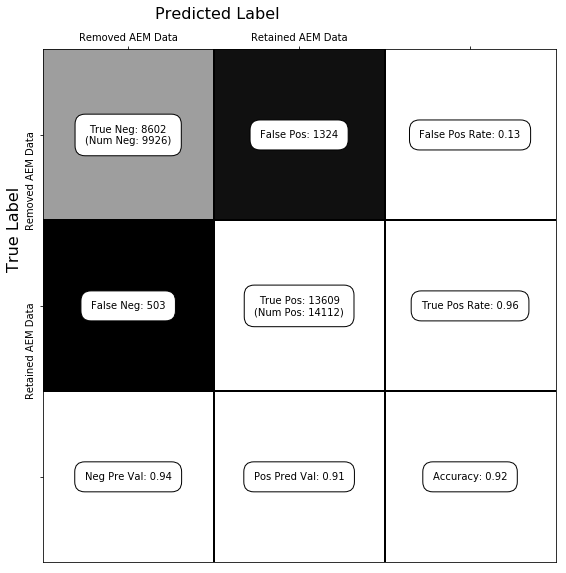

In [39]:
currResult=result8
currTest=X_test8
meanLabels=(currResult[0][0].predict(currTest)+currResult[0][1].predict(currTest)+currResult[0][2].predict(currTest)+currResult[0][3].predict(currTest)+currResult[0][4].predict(currTest))/5
meanLabels=np.round(meanLabels)

confusionMat = sklearn.metrics.confusion_matrix(Y_test8,meanLabels)

show_confusion_matrix(confusionMat, ['Removed AEM Data', 'Retained AEM Data'])
plt.savefig('confusionMat_Butte_on_K_w_01pct.png')

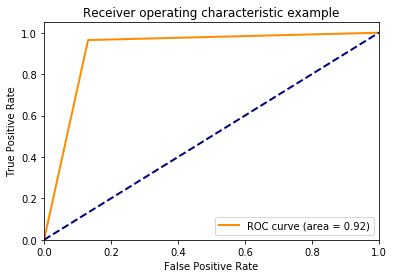

In [34]:
# didn't end up using this

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y = label_binarize(Y_test6, classes=[0, 1])
y_meanlab = label_binarize(meanLabels, classes=[0, 1])
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_meanlab[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_meanlab.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [51]:
result7[0][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 9, 37, 16)         592       
_________________________________________________________________
max_pooling2d_231 (MaxPoolin (None, 9, 18, 16)         0         
_________________________________________________________________
leaky_re_lu_231 (LeakyReLU)  (None, 9, 18, 16)         0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 9, 18, 32)         7712      
_________________________________________________________________
max_pooling2d_232 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
leaky_re_lu_232 (LeakyReLU)  (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 9, 9, 64)          43072     
__________

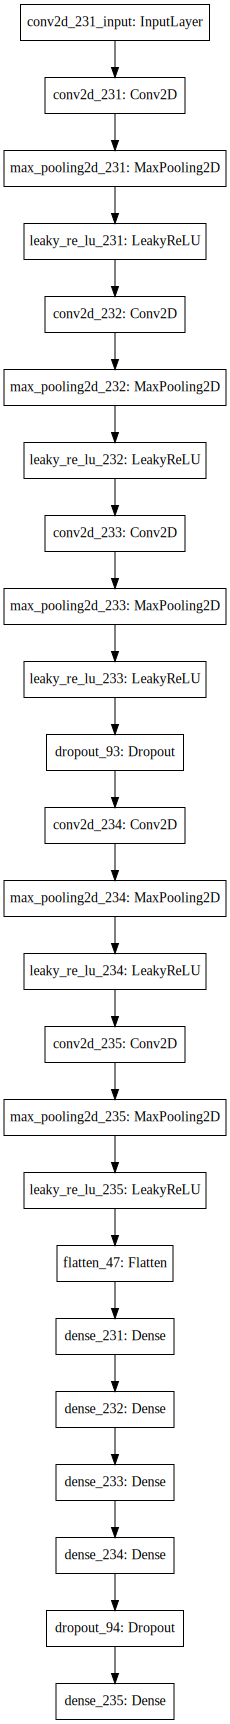

In [52]:
plot_model(result7[0][0], to_file='Model_graph.png')
SVG(model_to_dot(result7[0][0]).create(prog='dot', format='svg'))